# Retail Price Optimization

In [ ]:
# Research questions in this price optimization project:

# What are the key factors influencing product demand and pricing?
# Analyzing variables like competitor pricing, product features, freight costs, and customer behavior.

# How does price elasticity impact demand?
# Identifying how changes in unit prices affect quantities sold and overall revenue.

# What are the optimal pricing strategies for maximizing revenue and profit?
# Using simulations and modeling to explore revenue-maximizing price points.

# How can advanced techniques like utility optimization and fuzzy logic enhance pricing decisions?
# Exploring how these methods adjust prices based on factors like inventory, demand, and competition.

# What role do competitor prices and customer segmentation play in dynamic pricing?
# Using competitor data and customer segmentation to refine pricing strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import zipfile

In [2]:
# Extract the ZIP file
zip_file_path = 'Retail Price Optimization.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('retail_price_data')

# Load the dataset
csv_file_path = 'retail_price_data/retail_price.csv'
data = pd.read_csv(csv_file_path)

# Debugging: Check the structure of 'unit_price'
if 'unit_price' in data.columns:
    print(f"'unit_price' column type: {type(data['unit_price'])}, shape: {data['unit_price'].shape}")
    if isinstance(data['unit_price'], pd.DataFrame):
        print("unit_price is a DataFrame, selecting the first column explicitly.")
        data['unit_price'] = data['unit_price'].iloc[:, 0]  # Select the first column explicitly
    elif data['unit_price'].ndim > 1:  # If it's not a DataFrame but still multidimensional
        print("unit_price has multiple dimensions, flattening to a single column.")
        data['unit_price'] = pd.Series(data['unit_price'].values[:, 0], index=data.index)  # Flatten to 1D

# Final Validation: Ensure 'unit_price' is a Series
if not isinstance(data['unit_price'], pd.Series):
    raise ValueError("unit_price is still not a Series after fixing at loading step.")
print(f"unit_price successfully fixed. Type: {type(data['unit_price'])}, Shape: {data['unit_price'].shape}")

print("Dataset Overview:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

'unit_price' column type: <class 'pandas.core.series.Series'>, shape: (676,)
unit_price successfully fixed. Type: <class 'pandas.core.series.Series'>, Shape: (676,)
Dataset Overview:
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4  

In [3]:
# Ensure 'unit_price' is a single-column Series
if isinstance(data['unit_price'], pd.DataFrame):
    print("unit_price is a DataFrame, selecting the first column explicitly.")
    data['unit_price'] = data['unit_price'].iloc[:, 0]  # Select the first column

# Confirm the fix
print(f"unit_price type after fix: {type(data['unit_price'])}")
print(f"unit_price shape after fix: {data['unit_price'].shape}")

unit_price type after fix: <class 'pandas.core.series.Series'>
unit_price shape after fix: (676,)


In [4]:
assert isinstance(data['unit_price'], pd.Series), "unit_price is not a Series."
assert data['unit_price'].notnull().all(), "unit_price contains null values."
assert (data['unit_price'] > 0).all(), "unit_price contains non-positive values."

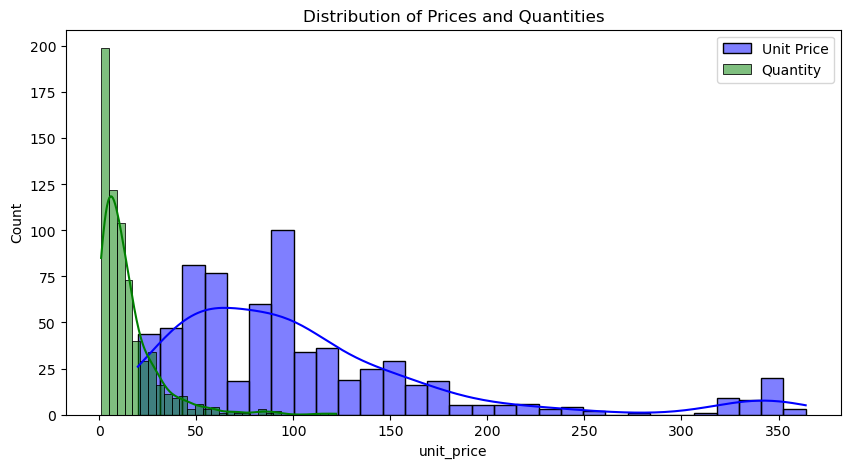

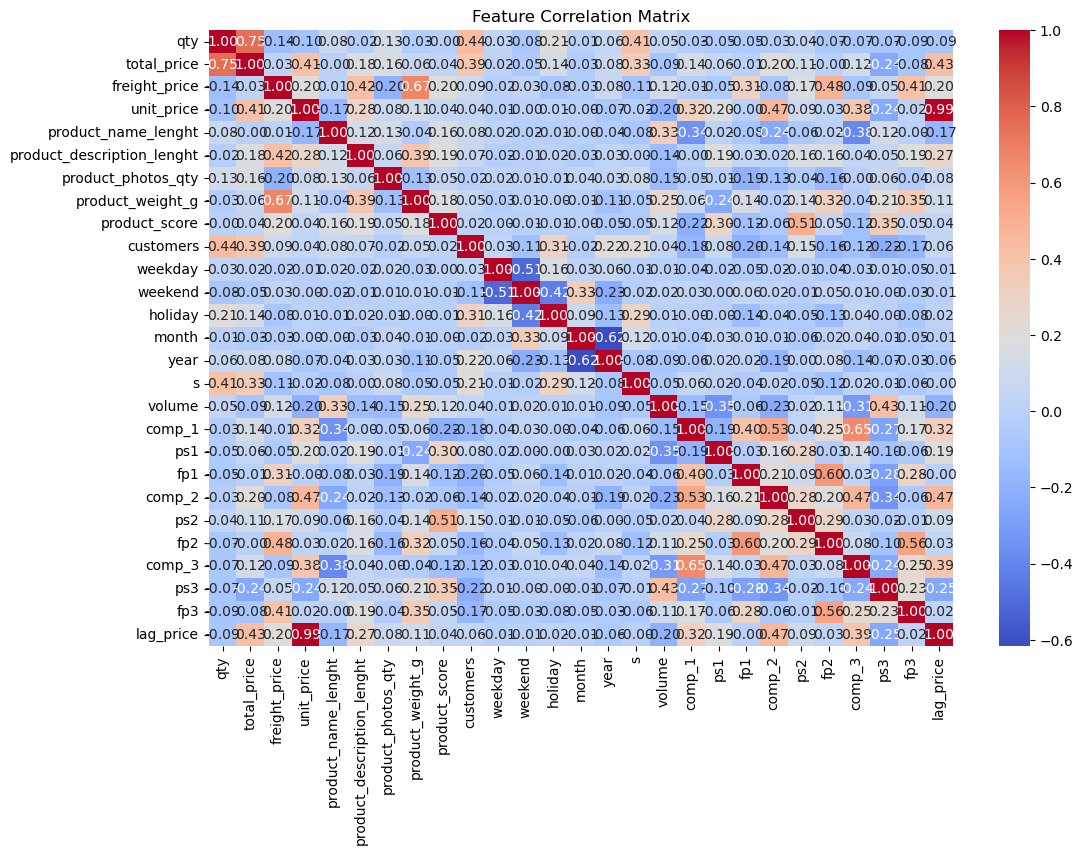

In [5]:
# Step 2: Visualize Key Features
def visualize_data(data):
    plt.figure(figsize=(10, 5))
    sns.histplot(data['unit_price'], kde=True, color='blue', bins=30, label='Unit Price')
    sns.histplot(data['qty'], kde=True, color='green', bins=30, label='Quantity')
    plt.title("Distribution of Prices and Quantities")
    plt.legend()
    plt.show()

    # Correlation Heatmap
    numerical_features = data.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Feature Correlation Matrix")
    plt.show()

visualize_data(data)

In [6]:
# Step 3: Feature Engineering with Debugging and Fixes
scaler = MinMaxScaler()
numeric_features = ['unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3']

# Debugging: Check initial numeric features
print("Initial Numeric Features:")
print(data[numeric_features].head())

# Ensure 'unit_price' and 'freight_price' are single-column Series
for col in ['unit_price', 'freight_price']:
    if isinstance(data[col], pd.DataFrame):
        print(f"{col} is a DataFrame, selecting the first column explicitly.")
        data[col] = data[col].iloc[:, 0]  # Select the first column explicitly

# Debugging: Confirm fixes
for col in ['unit_price', 'freight_price']:
    print(f"{col} type after fix: {type(data[col])}, shape: {data[col].shape}")

# Apply scaling
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Debugging: Check scaled numeric features
print("\nScaled Numeric Features:")
print(data[numeric_features].head())

Initial Numeric Features:
   unit_price  freight_price  comp_1      comp_2  comp_3
0       45.95      15.100000    89.9  215.000000   45.95
1       45.95      12.933333    89.9  209.000000   45.95
2       45.95      14.840000    89.9  205.000000   45.95
3       45.95      14.287500    89.9  199.509804   45.95
4       45.95      15.100000    89.9  163.398710   45.95
unit_price type after fix: <class 'pandas.core.series.Series'>, shape: (676,)
freight_price type after fix: <class 'pandas.core.series.Series'>, shape: (676,)

Scaled Numeric Features:
   unit_price  freight_price    comp_1    comp_2    comp_3
0    0.075705       0.189318  0.212121  0.591212  0.110517
1    0.075705       0.162153  0.212121  0.573030  0.110517
2    0.075705       0.186058  0.212121  0.560909  0.110517
3    0.075705       0.179131  0.212121  0.544272  0.110517
4    0.075705       0.189318  0.212121  0.434845  0.110517


In [7]:
# Create Interaction Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Debugging: Check input features for PolynomialFeatures
print("Input Features for PolynomialFeatures:")
print(data[numeric_features].head())

# Fit and transform
interaction_data = poly.fit_transform(data[numeric_features])

# Get feature names directly
interaction_features = poly.get_feature_names_out()  # No need to pass `numeric_features`

# Debugging: Confirm generated feature names
print("\nGenerated Interaction Features:")
print(interaction_features)

# Create DataFrame for interaction features
interaction_df = pd.DataFrame(interaction_data, columns=interaction_features, index=data.index)

# Debugging: Check the shape of interaction features
print(f"Interaction Features Shape: {interaction_df.shape}")

# Concatenate interaction features with the original data
data = pd.concat([data.drop(columns=numeric_features), pd.DataFrame(data[numeric_features], index=data.index), interaction_df], axis=1)

# Debugging: Confirm concatenated data
print(f"Data Shape After Adding Interaction Features: {data.shape}")
print(data.head())

Input Features for PolynomialFeatures:
   unit_price  freight_price    comp_1    comp_2    comp_3
0    0.075705       0.189318  0.212121  0.591212  0.110517
1    0.075705       0.162153  0.212121  0.573030  0.110517
2    0.075705       0.186058  0.212121  0.560909  0.110517
3    0.075705       0.179131  0.212121  0.544272  0.110517
4    0.075705       0.189318  0.212121  0.434845  0.110517

Generated Interaction Features:
['unit_price' 'freight_price' 'comp_1' 'comp_2' 'comp_3'
 'unit_price freight_price' 'unit_price comp_1' 'unit_price comp_2'
 'unit_price comp_3' 'freight_price comp_1' 'freight_price comp_2'
 'freight_price comp_3' 'comp_1 comp_2' 'comp_1 comp_3' 'comp_2 comp_3']
Interaction Features Shape: (676, 15)
Data Shape After Adding Interaction Features: (676, 45)
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed

In [8]:
# Step 4: Define Target and Features

# Drop identifier and irrelevant columns
irrelevant_columns = ['product_id', 'month_year']  # Add other non-predictive columns
X = data.drop(columns=irrelevant_columns + ['qty', 'total_price'], errors='ignore')

# Debugging: Check for remaining non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns detected before conversion: {non_numeric_columns}")

# Convert boolean columns and other non-numeric columns to numeric
for col in non_numeric_columns:
    print(f"Converting non-numeric column '{col}' to numeric.")
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Validate numeric conversion
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    raise ValueError(f"The following columns in X are not numeric after conversion: {non_numeric_columns}")

# Debugging: Confirm numeric conversion
print("\nAll columns in X are numeric.")
print(f"Updated Features Shape (X): {X.shape}")

# Define target
y = data['qty']

# Debugging: Confirm shapes
print(f"\nFeatures Shape (X): {X.shape}")
print(f"Target Shape (y): {y.shape}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Confirm splits
print("\nTrain-Test Split Completed!")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Non-numeric columns detected before conversion: Index(['product_category_name'], dtype='object')
Converting non-numeric column 'product_category_name' to numeric.

All columns in X are numeric.
Updated Features Shape (X): (676, 41)

Features Shape (X): (676, 41)
Target Shape (y): (676,)

Train-Test Split Completed!
Training samples: 540, Testing samples: 136


In [9]:
# Check the content of 'product_category_name' in X_train and X_test
print("Unique values in 'product_category_name' (Training):")
print(X_train['product_category_name'].unique())

print("\nUnique values in 'product_category_name' (Testing):")
print(X_test['product_category_name'].unique())

# Check for all missing values
print("\nMissing values in 'product_category_name':")
print(f"Training Set: {X_train['product_category_name'].isnull().sum()}")
print(f"Testing Set: {X_test['product_category_name'].isnull().sum()}")


Unique values in 'product_category_name' (Training):
[nan]

Unique values in 'product_category_name' (Testing):
[nan]

Missing values in 'product_category_name':
Training Set: 540
Testing Set: 136


In [10]:
# Check if the column is entirely NaN
if X_train['product_category_name'].isnull().all() and X_test['product_category_name'].isnull().all():
    # Drop the column from both datasets
    X_train.drop(columns=['product_category_name'], inplace=True, errors='ignore')
    X_test.drop(columns=['product_category_name'], inplace=True, errors='ignore')
    print("'product_category_name' column dropped from both datasets.")
else:
    print("Non-NaN values found in 'product_category_name'. Check preprocessing steps.")


'product_category_name' column dropped from both datasets.


In [11]:
# Step: Ensure that all one-hot encoded columns are numeric

# Convert all columns in training and testing sets to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Check for any remaining non-numeric columns
non_numeric_columns_train = X_train.select_dtypes(exclude=[np.number]).columns
non_numeric_columns_test = X_test.select_dtypes(exclude=[np.number]).columns

if len(non_numeric_columns_train) > 0 or len(non_numeric_columns_test) > 0:
    raise ValueError(
        f"Non-numeric columns detected: "
        f"\nTraining: {non_numeric_columns_train.tolist()}"
        f"\nTesting: {non_numeric_columns_test.tolist()}"
    )

# Debugging: Confirm data types in training and testing sets
print("\nTraining Features Data Types After Conversion:")
print(X_train.dtypes.value_counts())

print("\nTesting Features Data Types After Conversion:")
print(X_test.dtypes.value_counts())

# Ensure no missing values after numeric conversion
if X_train.isnull().sum().any() or X_test.isnull().sum().any():
    print("\nWarning: Missing values detected after numeric conversion!")
    print("Training Missing Values:")
    print(X_train.isnull().sum())
    print("Testing Missing Values:")
    print(X_test.isnull().sum())
    raise ValueError("Missing values detected after numeric conversion.")

# Build and Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Debugging: Confirm model training completion
print("\nRandom Forest Model trained successfully!")



Training Features Data Types After Conversion:
float64    29
int64      11
Name: count, dtype: int64

Testing Features Data Types After Conversion:
float64    29
int64      11
Name: count, dtype: int64

Random Forest Model trained successfully!



Model Evaluation Metrics:
Mean Squared Error (MSE): 101.85
Mean Absolute Error (MAE): 6.24
R² Score: 0.62

Sample of Actual vs Predicted Values:
   Actual  Predicted
0      18      18.67
1      14       9.53
2       1      25.87
3      28      29.66
4       3      21.69
5       9       9.76
6      32      20.83
7      82      61.32
8      12      14.49
9       7       4.35


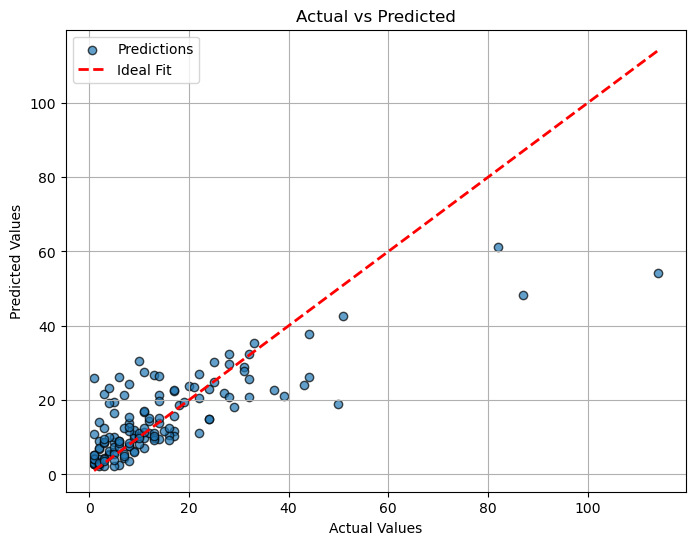

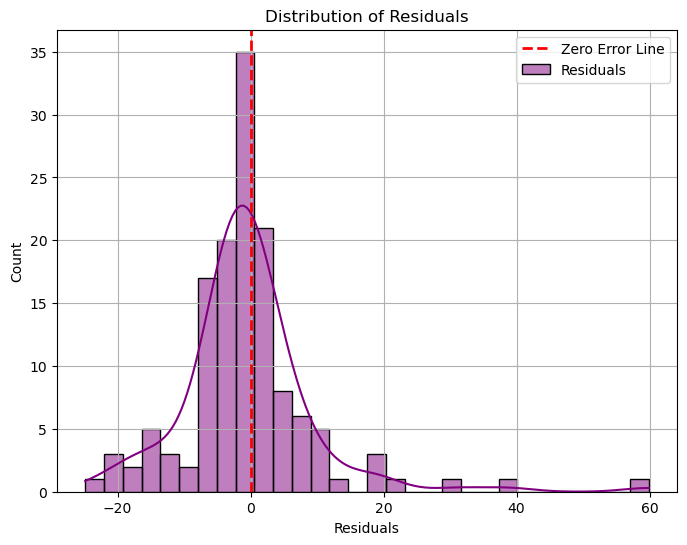

In [12]:
# Step 6: Model Evaluation
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics with descriptive labels
print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Debugging: Examine a sample of predictions vs actuals
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})
print("\nSample of Actual vs Predicted Values:")
print(comparison_df.head(10))

# Optional: Visualize Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Distribution of Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple', label="Residuals")
plt.axvline(0, color='r', linestyle='--', lw=2, label="Zero Error Line")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()

unit_price is a DataFrame, selecting the first column explicitly.
unit_price type: <class 'pandas.core.frame.DataFrame'>, shape: (676, 2)
Error while cleaning 'unit_price': The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Price Range: [0.         0.         0.02040816 0.02040816 0.04081633 0.04081633
 0.06122449 0.06122449 0.08163265 0.08163265 0.10204082 0.10204082
 0.12244898 0.12244898 0.14285714 0.14285714 0.16326531 0.16326531
 0.18367347 0.18367347 0.20408163 0.20408163 0.2244898  0.2244898
 0.24489796 0.24489796 0.26530612 0.26530612 0.28571429 0.28571429
 0.30612245 0.30612245 0.32653061 0.32653061 0.34693878 0.34693878
 0.36734694 0.36734694 0.3877551  0.3877551  0.40816327 0.40816327
 0.42857143 0.42857143 0.44897959 0.44897959 0.46938776 0.46938776
 0.48979592 0.48979592 0.51020408 0.51020408 0.53061224 0.53061224
 0.55102041 0.55102041 0.57142857 0.57142857 0.59183673 0.59183673
 0.6122449  0.6122449  0.63265306 0.63265306 0.653

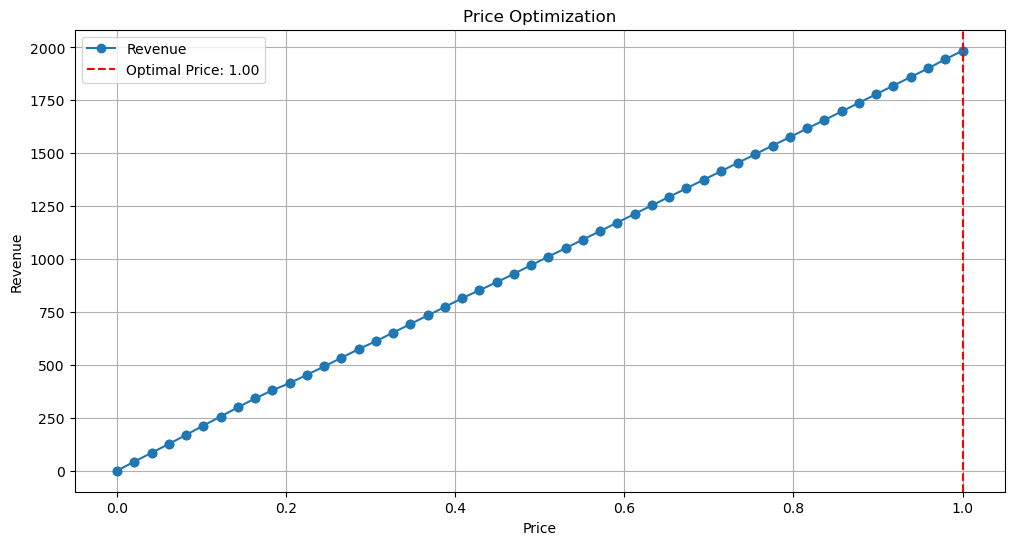


Optimal Price: 1.00
Maximum Revenue: 1984.27


In [13]:
# Step 6: Ensure 'unit_price' is a single-column Series and Clean Data

# Check if 'unit_price' is a DataFrame, and extract the first column if needed
if isinstance(data['unit_price'], pd.DataFrame):
    print("unit_price is a DataFrame, selecting the first column explicitly.")
    data['unit_price'] = data['unit_price'].iloc[:, 0]  # Select the first column

# Debugging: Confirm 'unit_price' type and shape
print(f"unit_price type: {type(data['unit_price'])}, shape: {data['unit_price'].shape}")

# Clean 'unit_price': Replace missing or invalid values
try:
    # Check for missing or invalid values in 'unit_price'
    if data['unit_price'].isnull().any() or (data['unit_price'] <= 0).any():
        print("Cleaning invalid or missing values in 'unit_price'...")
        
        # Calculate the mean of valid values
        valid_mean = data.loc[data['unit_price'] > 0, 'unit_price'].mean()
        print(f"Mean of valid 'unit_price': {valid_mean:.2f}")
        
        # Replace non-positive values with the mean
        data['unit_price'] = data['unit_price'].where(data['unit_price'] > 0, valid_mean)
        # Fill missing values with the mean
        data['unit_price'].fillna(valid_mean, inplace=True)
    
    # Confirm cleaning
    print(f"Descriptive Statistics for 'unit_price':\n{data['unit_price'].describe()}")

except Exception as e:
    print(f"Error while cleaning 'unit_price': {e}")

# Step 7: Create Price Range for Optimization

# Generate a price range based on cleaned 'unit_price'
try:
    price_range = np.linspace(data['unit_price'].min(), data['unit_price'].max(), 50).flatten()
    # Debugging: Confirm price_range properties
    print(f"Price Range: {price_range}")
    print(f"Price Range Min: {price_range.min()}, Max: {price_range.max()}, Shape: {price_range.shape}")
except Exception as e:
    print(f"Error while generating price_range: {e}")

# Step 8: Price Optimization with Debugging and Fixes

# Initialize the list to store simulated revenue data
simulated_revenue = []

try:
    # Iterate through price range and calculate revenue
    for i, price in enumerate(price_range):
        price = float(price)  # Ensure scalar
        simulated_X_test = X_test.copy()
        simulated_X_test['unit_price'] = price  # Update unit_price with the current scalar price
        
        # Predict simulated quantities
        simulated_qty = model.predict(simulated_X_test)
        # Replace negative predictions with 0
        simulated_qty = np.maximum(simulated_qty, 0)

        # Calculate total revenue
        total_revenue = np.sum(simulated_qty * price)  # Revenue = price * quantity

        # Append price and revenue to the list
        simulated_revenue.append((price, total_revenue))

        # Debugging: Log iteration details periodically
        if i % 5 == 0 or i == len(price_range) - 1:
            print(f"Iteration {i + 1}: Price: {price:.2f}, Total Revenue: {total_revenue:.2f}")

    # Find the optimal price
    optimal_price = max(simulated_revenue, key=lambda x: x[1])

    # Visualization: Revenue vs. Price
    prices, revenues = zip(*simulated_revenue)
    plt.figure(figsize=(12, 6))
    plt.plot(prices, revenues, marker='o', label="Revenue")
    plt.axvline(optimal_price[0], color='red', linestyle='--', label=f"Optimal Price: {optimal_price[0]:.2f}")
    plt.title("Price Optimization")
    plt.xlabel("Price")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output the optimal price and revenue
    print(f"\nOptimal Price: {optimal_price[0]:.2f}")
    print(f"Maximum Revenue: {optimal_price[1]:.2f}")

except Exception as e:
    print(f"Error during price optimization: {e}")


In [22]:
# Step 8: Fuzzy Logic for Pricing Adjustment (Final Fix)

# Step 1: Verify and clean column names
print("\nColumn names before cleaning:")
print(data.columns)

# Remove any unintended spaces in column names
data.columns = [col.strip() for col in data.columns]

# Step 2: Validate combined columns
interaction_features = [col for col in data.columns if " " in col]
print("\nInteraction features detected:")
print(interaction_features)

# Check if interaction features are valid or need further review
# Uncomment the next line if you want to drop them entirely
# data.drop(columns=interaction_features, inplace=True)

# Step 3: Ensure all columns for modeling are numeric
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns detected:")
print(non_numeric_columns)

# Encode or drop non-numeric columns as necessary
if 'product_category_name' in non_numeric_columns:
    # Example: Encode 'product_category_name'
    data['product_category_name'] = data['product_category_name'].astype('category').cat.codes

if 'month_year' in non_numeric_columns:
    # Drop 'month_year' if it's not useful
    data.drop(columns=['month_year'], inplace=True)

# Confirm all columns are now numeric
print("\nConfirming numeric columns:")
print(data.select_dtypes(exclude=[np.number]).columns)

# Step 4: Check dataset info again
print("\nDataset info after cleaning:")
print(data.info())


Column names before cleaning:
Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_score', 'customers',
       'weekday', 'weekend', 'holiday', 'month', 'year', 's', 'volume', 'ps1',
       'fp1', 'ps2', 'fp2', 'ps3', 'fp3', 'lag_price', 'unit_price',
       'freight_price', 'comp_1', 'comp_2', 'comp_3',
       'unit_price freight_price', 'unit_price comp_1', 'unit_price comp_2',
       'unit_price comp_3', 'freight_price comp_1', 'freight_price comp_2',
       'freight_price comp_3', 'comp_1 comp_2', 'comp_1 comp_3',
       'comp_2 comp_3'],
      dtype='object')

Interaction features detected:
['unit_price freight_price', 'unit_price comp_1', 'unit_price comp_2', 'unit_price comp_3', 'freight_price comp_1', 'freight_price comp_2', 'freight_price comp_3', 'comp_1 comp_2', 'comp_1 comp_3', 'comp_2 comp_3']

Non-numeric columns detected:
Ind

In [23]:
# Step 1: Drop unnecessary columns
data.drop(columns=['product_id'], inplace=True)

# Step 2: Drop interaction features if not needed
interaction_features = [col for col in data.columns if " " in col]
print("Dropping interaction features:")
print(interaction_features)
data.drop(columns=interaction_features, inplace=True)

# Step 3: Split data into features and target
target_column = 'qty'
X = data.drop(columns=[target_column])
y = data[target_column]

# Step 4: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Print final feature shapes
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Target Shape: {y.shape}")

Dropping interaction features:
['unit_price freight_price', 'unit_price comp_1', 'unit_price comp_2', 'unit_price comp_3', 'freight_price comp_1', 'freight_price comp_2', 'freight_price comp_3', 'comp_1 comp_2', 'comp_1 comp_3', 'comp_2 comp_3']
Training Features Shape: (540, 27)
Testing Features Shape: (136, 27)
Target Shape: (676,)


In [30]:
# Step 9: Utility Optimization (Simplified Revenue Maximization)

# Ensure 'freight_price' is a proper Series
if isinstance(data['freight_price'], pd.DataFrame):
    print("freight_price is a DataFrame, selecting the first column explicitly.")
    data['freight_price'] = data['freight_price'].iloc[:, 0]  # Correctly select the first column

# Debugging: Confirm 'freight_price' is now a Series
print(f"freight_price type after fix: {type(data['freight_price'])}")
print(f"freight_price shape after fix: {data['freight_price'].shape}")

# Clean 'unit_price': Replace non-positive values with the mean of positive values
positive_mean_price = data.loc[data['unit_price'] > 0, 'unit_price'].mean()
if (data['unit_price'] <= 0).sum() > 0:
    print(f"Replacing {data['unit_price'].le(0).sum()} non-positive values in 'unit_price' with mean: {positive_mean_price:.2f}")
    data['unit_price'] = data['unit_price'].where(data['unit_price'] > 0, positive_mean_price)

# Debugging: Confirm cleaned 'unit_price' stats
print(f"Cleaned Min unit_price: {data['unit_price'].min()}")
print(f"Cleaned Max unit_price: {data['unit_price'].max()}")

# Generate price_range based on cleaned 'unit_price'
try:
    price_range = np.linspace(data['unit_price'].min(), data['unit_price'].max(), 50)
    # Debugging: Confirm price_range properties
    print(f"Price Range: {price_range}")
    print(f"Price Range Min: {price_range.min()}, Max: {price_range.max()}, Shape: {price_range.shape}")
except Exception as e:
    raise ValueError(f"Error generating price_range: {e}")

# Validate price_range
if price_range.size == 0 or price_range.min() <= 0:
    raise ValueError("Invalid price range detected. Ensure it has positive values and is not empty.")

# Calculate freight_price mean
try:
    freight_mean = data['freight_price'].mean()
    print(f"freight_price mean (scalar): {freight_mean:.2f}")
except Exception as e:
    raise ValueError(f"Error calculating freight_price mean: {e}")

# Check if freight_mean is valid
if np.isnan(freight_mean) or not np.isfinite(freight_mean):
    raise ValueError("freight_price mean is NaN or infinite. Check data preprocessing.")

# Define utility optimization function
def utility_optimization(prices, costs, min_margin=0):
    """
    Optimize utility by maximizing the difference between prices and costs.
    :param prices: Array of prices
    :param costs: Cost scalar or array
    :param min_margin: Minimum required margin between prices and costs
    :return: Price that maximizes the utility
    """
    if np.isscalar(costs):
        costs = np.full_like(prices, costs)
    utilities = np.where(prices >= costs + min_margin, prices - costs, -np.inf)
    print(f"Utilities Array: {utilities}")  # Debugging
    return prices[np.argmax(utilities)]

# Calculate utility-optimized price
try:
    optimal_utility_price = utility_optimization(price_range, freight_mean, min_margin=0.05)  # Example margin
    print(f"Utility-Optimized Price: {optimal_utility_price:.2f}")
except Exception as e:
    print(f"Error during utility optimization: {e}")

freight_price type after fix: <class 'pandas.core.series.Series'>
freight_price shape after fix: (676,)
Replacing 6 non-positive values in 'unit_price' with mean: 0.25
Cleaned Min unit_price: 0.00026155187445509737
Cleaned Max unit_price: 0.9999999999999998
Price Range: [2.61551874e-04 2.06643773e-02 4.10672028e-02 6.14700283e-02
 8.18728538e-02 1.02275679e-01 1.22678505e-01 1.43081330e-01
 1.63484156e-01 1.83886981e-01 2.04289807e-01 2.24692632e-01
 2.45095458e-01 2.65498283e-01 2.85901108e-01 3.06303934e-01
 3.26706759e-01 3.47109585e-01 3.67512410e-01 3.87915236e-01
 4.08318061e-01 4.28720887e-01 4.49123712e-01 4.69526538e-01
 4.89929363e-01 5.10332189e-01 5.30735014e-01 5.51137840e-01
 5.71540665e-01 5.91943491e-01 6.12346316e-01 6.32749142e-01
 6.53151967e-01 6.73554792e-01 6.93957618e-01 7.14360443e-01
 7.34763269e-01 7.55166094e-01 7.75568920e-01 7.95971745e-01
 8.16374571e-01 8.36777396e-01 8.57180222e-01 8.77583047e-01
 8.97985873e-01 9.18388698e-01 9.38791524e-01 9.59194349e-

# Key Questions

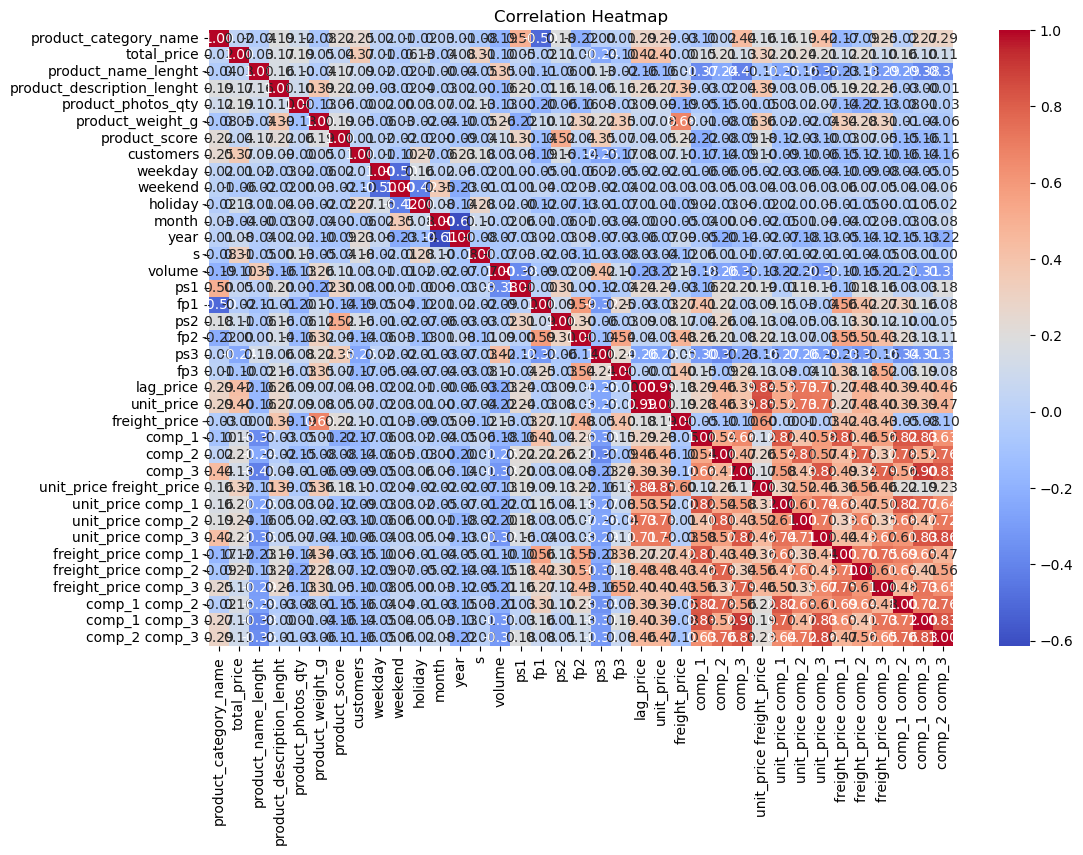

In [71]:
# # Key Factors Influencing Product Demand and Pricing

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [72]:
corr_matrix

,product_category_name,total_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,...,unit_price freight_price,unit_price comp_1,unit_price comp_2,unit_price comp_3,freight_price comp_1,freight_price comp_2,freight_price comp_3,comp_1 comp_2,comp_1 comp_3,comp_2 comp_3
product_category_name,1.000000,0.018576,-0.035065,0.187638,0.116953,-0.079052,0.219714,0.247767,0.023638,0.013542,...,0.164023,0.161213,0.189830,0.422419,-0.169800,-0.089009,0.254694,-0.018882,0.271307,0.293625
total_price,0.018576,1.000000,0.025360,0.165515,0.192475,0.046141,0.042891,0.369332,0.012725,-0.056429,...,0.315998,0.199797,0.240498,0.212235,0.120422,0.212615,0.095010,0.162241,0.102215,0.113254
product_name_lenght,-0.035065,0.025360,1.000000,0.156506,0.098725,-0.038470,0.168691,0.091086,0.016265,-0.017488,...,-0.106204,-0.256008,-0.163332,-0.345548,-0.227332,-0.129254,-0.294075,-0.288140,-0.382196,-0.362366
product_description_lenght,0.187638,0.165515,0.156506,1.000000,0.099491,0.385837,0.220024,0.090598,-0.030483,-0.018236,...,0.394729,0.034709,0.046999,0.048086,0.190258,0.217041,0.259420,-0.034934,-0.001853,-0.011425
product_photos_qty,0.116953,0.192475,0.098725,0.099491,1.000000,-0.128311,0.064229,-0.001229,0.024646,0.000572,...,-0.052577,0.028493,0.023024,0.074007,-0.143014,-0.219277,-0.126413,-0.081318,0.008342,-0.027797
product_weight_g,-0.079052,0.046141,-0.038470,0.385837,-0.128311,1.000000,0.186212,0.049483,-0.057353,0.025078,...,0.363781,0.015394,-0.020620,-0.037370,0.342096,0.276070,0.311724,-0.010106,-0.042704,-0.061227
product_score,0.219714,0.042891,0.168691,0.220024,0.064229,0.186212,1.000000,0.012627,0.021637,-0.016364,...,0.176849,-0.122903,-0.032758,-0.099553,-0.031592,0.070927,0.051825,-0.154754,-0.163131,-0.113344
customers,0.247767,0.369332,0.091086,0.090598,-0.001229,0.049483,0.012627,1.000000,0.010957,-0.099014,...,0.099392,-0.086383,-0.098805,-0.056698,-0.149687,-0.117432,-0.101775,-0.159332,-0.140523,-0.156506
weekday,0.023638,0.012725,0.016265,-0.030483,0.024646,-0.057353,0.021637,0.010957,1.000000,-0.496561,...,-0.021455,-0.034539,-0.062949,-0.036454,-0.095186,-0.092580,-0.078740,-0.042581,-0.048275,-0.054453
weekend,0.013542,-0.056429,-0.017488,-0.018236,0.000572,0.025078,-0.016364,-0.099014,-0.496561,1.000000,...,0.035227,0.027923,0.055601,0.030580,0.062432,0.074082,0.052181,0.043674,0.040108,0.062473


C:\Users\milto\AppData\Local\Temp\ipykernel_31352\3746149692.py:16: RuntimeWarning: invalid value encountered in divide
  elasticity = quantity_changes / price_changes


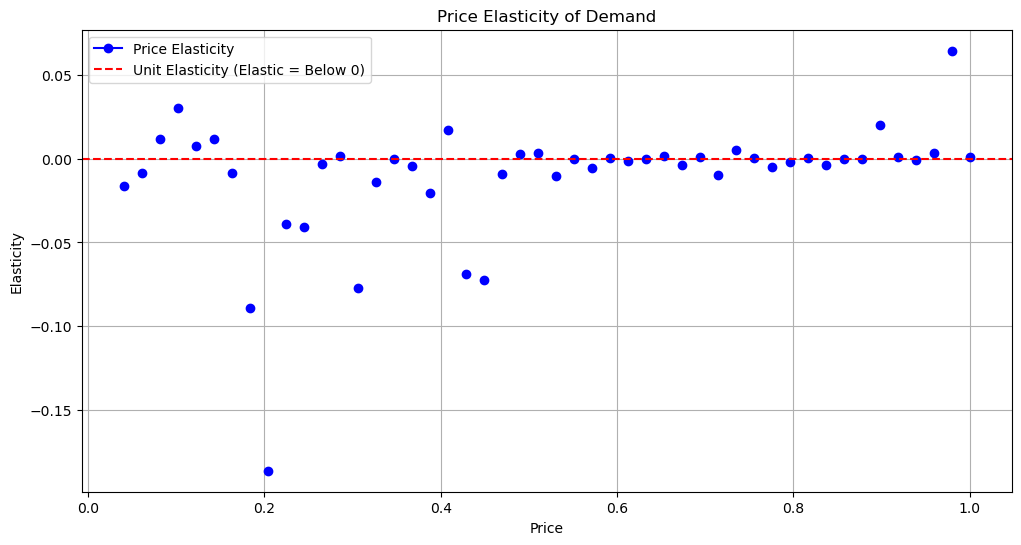

In [40]:
# Price Elasticity Calculation
def calculate_price_elasticity(price_range, simulated_revenue):
    prices, revenues = zip(*simulated_revenue)
    quantities = [revenue / price if price > 0 else 0 for price, revenue in simulated_revenue]  # Avoid division by zero

    # Remove invalid data points where price or quantity is zero
    valid_indices = [i for i, price in enumerate(prices) if price > 0]
    prices = np.array(prices)[valid_indices]
    quantities = np.array(quantities)[valid_indices]

    # Percentage changes in price and quantity
    price_changes = np.diff(prices) / prices[:-1]
    quantity_changes = np.diff(quantities) / quantities[:-1]

    # Compute elasticity
    elasticity = quantity_changes / price_changes
    return prices[1:], elasticity  # Skip the first price as diff reduces array size

# Elasticity Calculation
try:
    prices, elasticity = calculate_price_elasticity(price_range, simulated_revenue)

    # Visualize Price Elasticity
    plt.figure(figsize=(12, 6))
    plt.plot(prices, elasticity, marker='o', label="Price Elasticity", color='blue')
    plt.axhline(0, color='red', linestyle='--', label="Unit Elasticity (Elastic = Below 0)")
    plt.title("Price Elasticity of Demand")
    plt.xlabel("Price")
    plt.ylabel("Elasticity")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error calculating price elasticity: {e}")


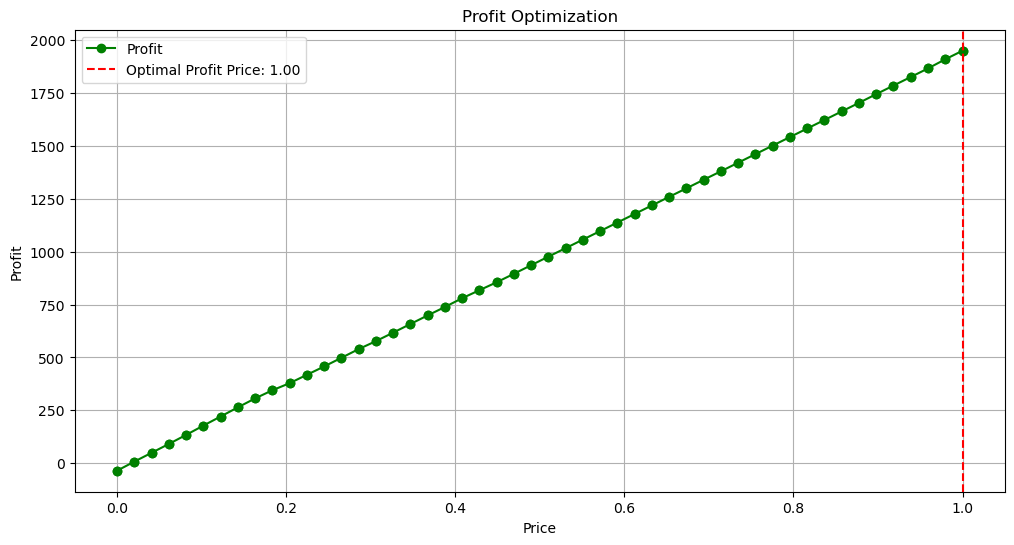


Optimal Profit Price: 1.00
Maximum Profit: 1949.00


In [41]:
# What Are the Optimal Pricing Strategies for Maximizing Revenue and Profit?

# Calculate Profit for Each Price Point
simulated_profit = [(price, revenue - (data['freight_price'].mean() * len(y_test))) for price, revenue in simulated_revenue]

# Find the Price that Maximizes Profit
optimal_profit_price = max(simulated_profit, key=lambda x: x[1])

# Visualize Profit vs. Price
prices, profits = zip(*simulated_profit)
plt.figure(figsize=(12, 6))
plt.plot(prices, profits, marker='o', label="Profit", color='green')
plt.axvline(optimal_profit_price[0], color='red', linestyle='--', label=f"Optimal Profit Price: {optimal_profit_price[0]:.2f}")
plt.title("Profit Optimization")
plt.xlabel("Price")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()

# Output the Optimal Price and Profit
print(f"\nOptimal Profit Price: {optimal_profit_price[0]:.2f}")
print(f"Maximum Profit: {optimal_profit_price[1]:.2f}")


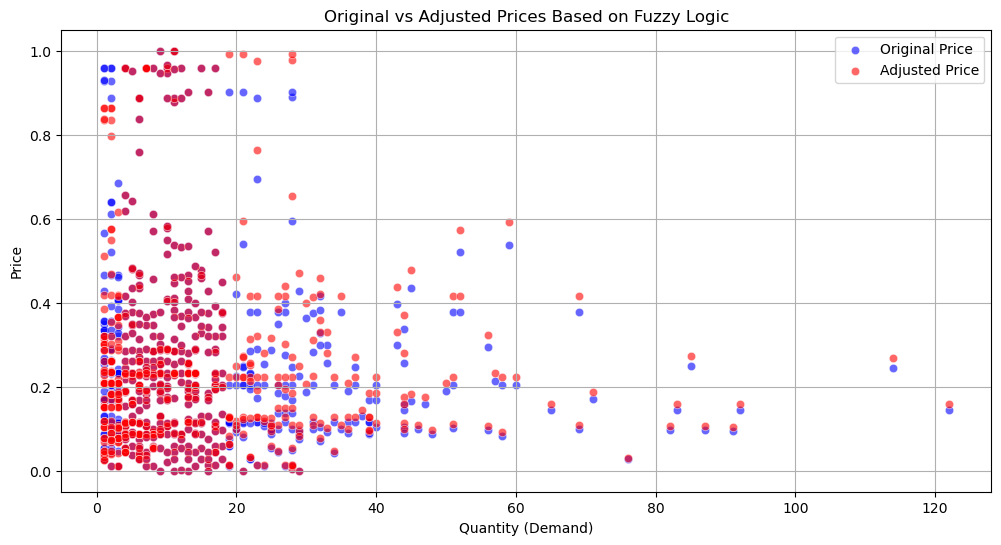

In [34]:
# How Can Advanced Techniques Enhance Pricing Decisions?
# Fuzzy Logic for Price Adjustment

# Fuzzy Logic Price Adjustment
high_demand_threshold = np.percentile(data['qty'], 75)
low_demand_threshold = np.percentile(data['qty'], 25)

def fuzzy_logic_price_adjustment(price, demand):
    if demand > high_demand_threshold:  # High demand
        return price * 1.1  # Increase price by 10%
    elif demand < low_demand_threshold:  # Low demand
        return price * 0.9  # Decrease price by 10%
    else:
        return price  # No adjustment

data['adjusted_price'] = data.apply(lambda row: fuzzy_logic_price_adjustment(row['unit_price'], row['qty']), axis=1)

# Visualize Original vs Adjusted Prices
plt.figure(figsize=(12, 6))
sns.scatterplot(x='qty', y='unit_price', data=data, label='Original Price', color='blue', alpha=0.6)
sns.scatterplot(x='qty', y='adjusted_price', data=data, label='Adjusted Price', color='red', alpha=0.6)
plt.title("Original vs Adjusted Prices Based on Fuzzy Logic")
plt.xlabel("Quantity (Demand)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


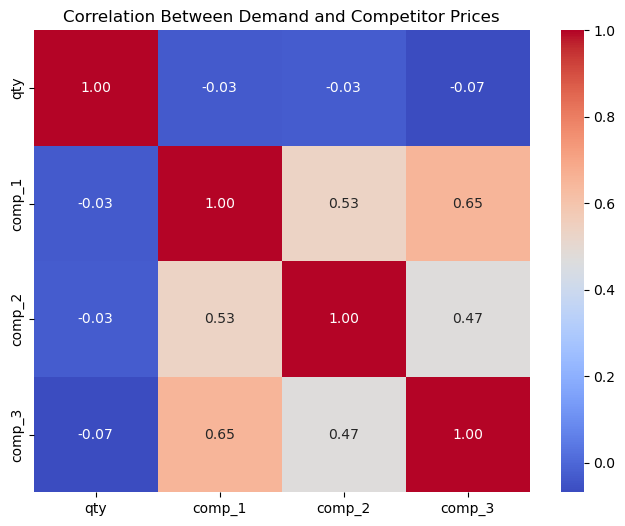

In [35]:
# What Role Do Competitor Prices and Customer Segmentation Play?
# Competitor Prices

# Correlation Between Competitor Prices and Demand
competitor_features = ['comp_1', 'comp_2', 'comp_3']
correlations = data[['qty'] + competitor_features].corr()

# Visualize Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Demand and Competitor Prices")
plt.show()


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


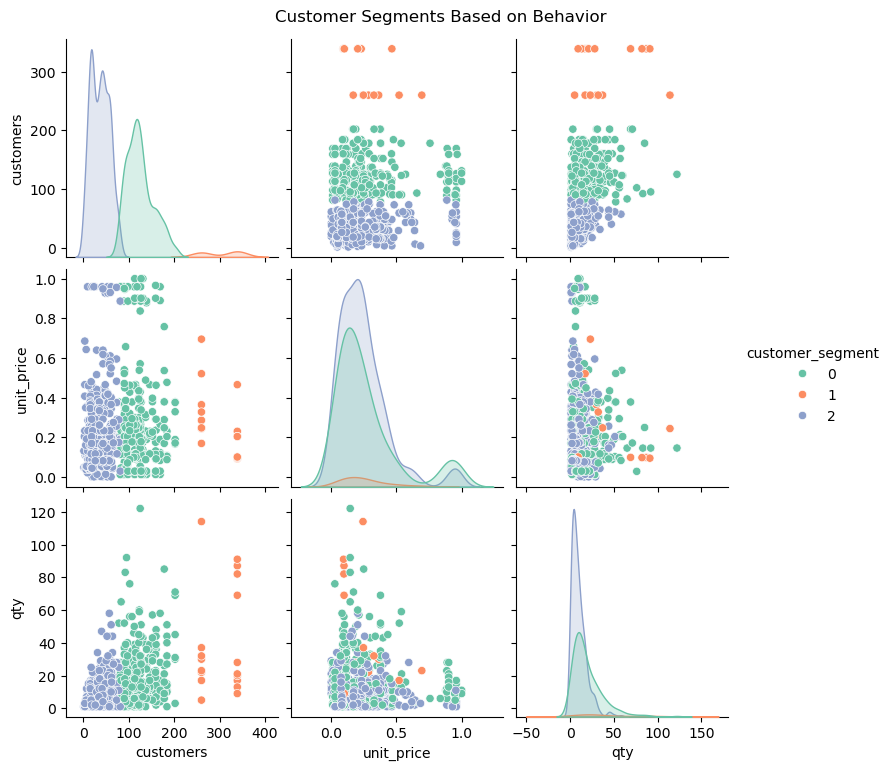

In [36]:
# Customer Segmentation

# Customer Segmentation Using KMeans
from sklearn.cluster import KMeans

customer_features = ['customers', 'unit_price', 'qty']
kmeans = KMeans(n_clusters=3, random_state=42)
data['customer_segment'] = kmeans.fit_predict(data[customer_features])

# Visualize Customer Segments
sns.pairplot(data, hue='customer_segment', vars=customer_features, palette="Set2")
plt.suptitle("Customer Segments Based on Behavior", y=1.02)
plt.show()


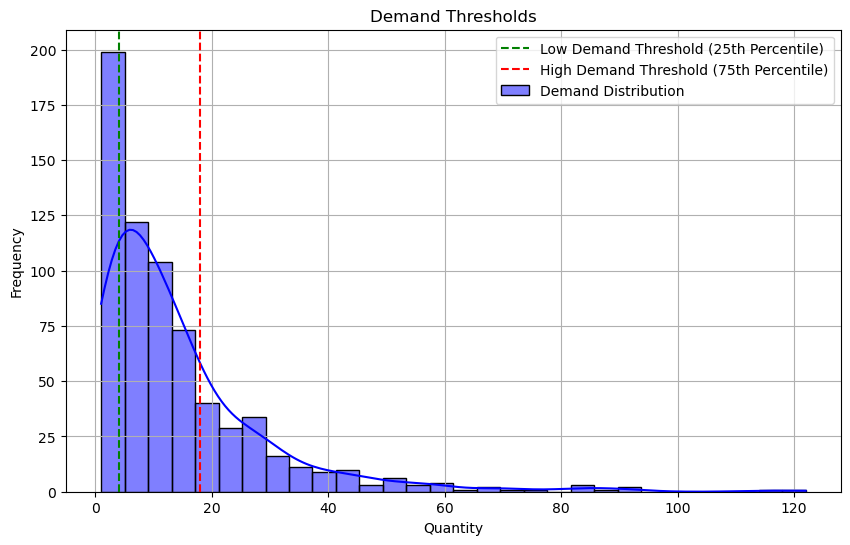

In [37]:
# Additional Visualizations:
# Demand Thresholds

plt.figure(figsize=(10, 6))
sns.histplot(data['qty'], bins=30, color='blue', kde=True, label="Demand Distribution")
plt.axvline(low_demand_threshold, color='green', linestyle='--', label="Low Demand Threshold (25th Percentile)")
plt.axvline(high_demand_threshold, color='red', linestyle='--', label="High Demand Threshold (75th Percentile)")
plt.title("Demand Thresholds")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


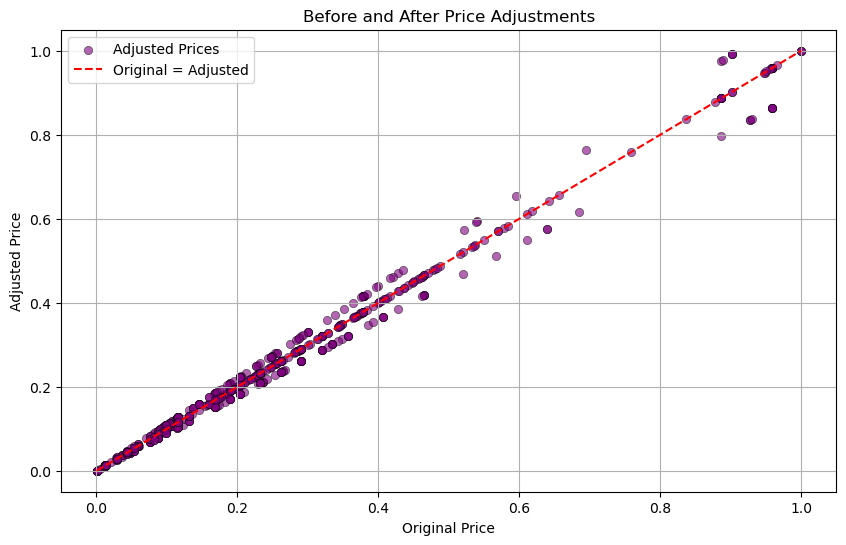

In [38]:
# Original vs Adjusted Prices Scatter Plot

plt.figure(figsize=(10, 6))
sns.scatterplot(x='unit_price', y='adjusted_price', data=data, color='purple', alpha=0.6, edgecolor='k', label="Adjusted Prices")
plt.plot([data['unit_price'].min(), data['unit_price'].max()], 
         [data['unit_price'].min(), data['unit_price'].max()], 
         'r--', label="Original = Adjusted")
plt.title("Before and After Price Adjustments")
plt.xlabel("Original Price")
plt.ylabel("Adjusted Price")
plt.legend()
plt.grid(True)
plt.show()
